# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.10.8, pytest-7.4.0, pluggy-1.0.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /root
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  /opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
    warnings.warn(_create_warning_msg(

-- Docs: https://d

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [21]:
valid_size = 0.2  # fraction of the training data to reserve for validation
num_classes = 50  # number of classes. Do not change this

In [8]:
import random
import numpy as np

n_grid = 6

batch_sizes = [int(2 ** (random.randint(4, 7))) for i in range(n_grid)]
learning_rates = [10 ** (random.uniform(np.log10(0.00005), np.log10(0.0007))) for i in range(n_grid)]
weight_decays = [10 ** (random.uniform(np.log10(1e-5), np.log10(1e-2))) for i in range(n_grid)]

parameters = zip(batch_sizes, learning_rates, weight_decays)

print(parameters)

In [9]:
print(batch_sizes)
print(learning_rates)
print(weight_decays)

[32, 32, 16, 32, 128, 32]
[0.0001636142350273523, 0.00010418667405729724, 0.0004957919527615587, 0.00037039097962751356, 7.620088635298905e-05, 0.00015252471225242869]
[6.817325416781117e-05, 4.4252854145194456e-05, 0.001952011567855052, 2.0259598275933325e-05, 0.00013796912242820182, 0.00011938180513976207]


In [4]:
import mlflow
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
from src.additional_functions import accuracy


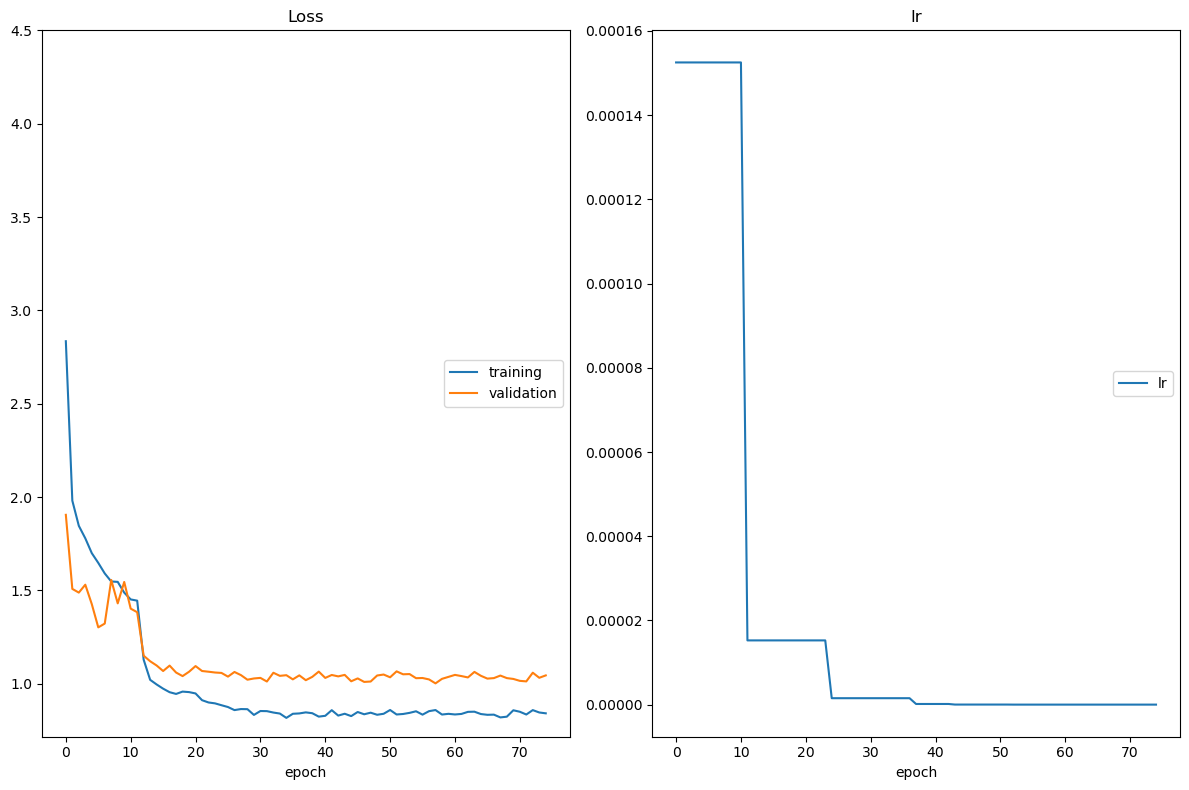

Train loss: 0.7189633846282959. Validation loss: 1.0322613716125488

Train accuracy: 80.01%. Validation accuracy: 73.96%


In [10]:
import mlflow
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning
from src.additional_functions import accuracy

opt = 'adam'
num_epochs = 75

for bs, lr, wd in parameters:
    with mlflow.start_run():

        model_transfer = get_model_transfer_learning(model_name='resnet152', fine_tuning=False, n_classes=num_classes) # YOUR CODE HERE

        # train the model
        data_loaders = get_data_loaders(batch_size=bs)
        optimizer = get_optimizer(
                        model_transfer,
                        learning_rate=lr,
                        optimizer=opt,
                        weight_decay=wd,
                        )
        loss = get_loss()

        optimize(
                data_loaders,
                model_transfer,
                optimizer,
                loss,
                n_epochs=num_epochs,
                save_path="best_val_loss_transfer.pt",
                interactive_tracking=True
                )

                        # Track values for hyperparameters    
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("batch_size", bs)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("opt", opt)
        mlflow.log_param("weight_decay", wd) 
        mlflow.log_param("type", "transfer_learning")
        mlflow.log_param("architecture", "B")

        train_acc, train_loss, val_acc, val_loss = accuracy(data_loaders, model_transfer, valid_size=valid_size, loss=loss)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("val_acc", val_acc)
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("val_loss", val_loss)

        mlflow.log_artifact("best_val_loss_transfer.pt")
            

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ I decided to use ResNet152 for the base of my model, since it performs fairly well on ImageNet and is not too large of a model. Also, since ResNet152 was trained for the ImageNet task, it is a good model to use for this landmark classificaiton task, since both ImageNet and this landmark task use images of natural scenes.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

In [7]:
import mlflow
runs = mlflow.search_runs().sort_values(by='metrics.val_loss', ascending=True)
transfer = runs[runs['params.type'] == 'transfer_learning']
transfer

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_acc,metrics.train_loss,metrics.val_loss,metrics.train_acc,...,params.batch_size,params.num_epochs,params.weight_decay,params.architecture,params.opt,params.dropout,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
4,abd64bb32b19429f92685195f99cf201,0,FINISHED,file:///root/mlruns/0/abd64bb32b19429f92685195...,2023-08-27 23:32:14.792000+00:00,2023-08-28 00:25:37.985000+00:00,73.959167,0.718963,1.032261,80.014008,...,32,75,0.00011938180513976207,B,adam,None,root,zealous-trout-882,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
9,e83d17f0bd744917bd69c50f70d7188e,0,FINISHED,file:///root/mlruns/0/e83d17f0bd744917bd69c50f...,2023-08-27 18:59:05.054000+00:00,2023-08-27 19:52:12.942000+00:00,71.156921,0.652109,1.082536,81.290031,...,32,75,6.817325416781117e-05,B,adam,None,root,merciful-pig-270,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
5,ce117013a0cb432dabd6b2dfdc3d7028,0,FINISHED,file:///root/mlruns/0/ce117013a0cb432dabd6b2df...,2023-08-27 22:31:50.033000+00:00,2023-08-27 23:32:14.773000+00:00,71.857483,0.744944,1.085928,79.038231,...,128,75,0.00013796912242820182,B,adam,None,root,kindly-stag-643,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
6,ddd06fe2b0cb4612b9ac0c90d68e0e8e,0,FINISHED,file:///root/mlruns/0/ddd06fe2b0cb4612b9ac0c90...,2023-08-27 21:38:26.679000+00:00,2023-08-27 22:31:50.013000+00:00,71.056847,0.624379,1.129710,81.890511,...,32,75,2.0259598275933325e-05,B,adam,None,root,omniscient-bug-565,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
7,097a10f7b28745c1b84218f341edd377,0,FINISHED,file:///root/mlruns/0/097a10f7b28745c1b84218f3...,2023-08-27 20:45:30.566000+00:00,2023-08-27 21:38:26.656000+00:00,68.755005,0.833279,1.140403,76.486191,...,16,75,0.001952011567855052,B,adam,None,root,thoughtful-cod-996,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
8,21b8d7f3a1644de0a3ef539cf0077379,0,FINISHED,file:///root/mlruns/0/21b8d7f3a1644de0a3ef539c...,2023-08-27 19:52:12.959000+00:00,2023-08-27 20:45:30.546000+00:00,69.055244,0.723724,1.221755,79.213371,...,32,75,4.4252854145194456e-05,B,adam,None,root,angry-shrimp-470,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL


In [15]:
path = 'mlruns/0/' + transfer.iloc[0, 0] +  '/artifacts/best_val_loss_transfer.pt'
path

'mlruns/0/abd64bb32b19429f92685195f99cf201/artifacts/best_val_loss_transfer.pt'

In [24]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning


def continue_training(path, fine_tuning=True, training_type='fine_tuning', architecture='B', model_name='resnet152', num_classes=50,learning_rate=1e-5, batch_size=64, optimizer='adam', weight_decay=0, num_epochs=45, valid_size=0.2):
    with mlflow.start_run():

        model_transfer = get_model_transfer_learning(model_name=model_name, fine_tuning=fine_tuning, n_classes=num_classes) # YOUR CODE HERE
        
        model_transfer.load_state_dict(torch.load(path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
        # train the model
        data_loaders = get_data_loaders(batch_size=batch_size)
        optimizer = get_optimizer(
                        model_transfer,
                        learning_rate=learning_rate,
                        optimizer=optimizer,
                        weight_decay=weight_decay,
                        )
        loss = get_loss()

        optimize(
                data_loaders,
                model_transfer,
                optimizer,
                loss,
                n_epochs=num_epochs,
                save_path="best_val_loss_transfer.pt",
                interactive_tracking=True
                )

                        # Track values for hyperparameters    
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("opt", optimizer)
        mlflow.log_param("weight_decay", weight_decay) 
        mlflow.log_param("type", training_type)
        mlflow.log_param("architecture", architecture)

        train_acc, train_loss, val_acc, val_loss = accuracy(data_loaders, model_transfer, valid_size=valid_size, loss=loss)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("val_acc", val_acc)
        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("val_loss", val_loss)

        mlflow.log_artifact("best_val_loss_transfer.pt")

### Fine Tuning

Here we unfreeze the last layer of the backbone and fine tune the model

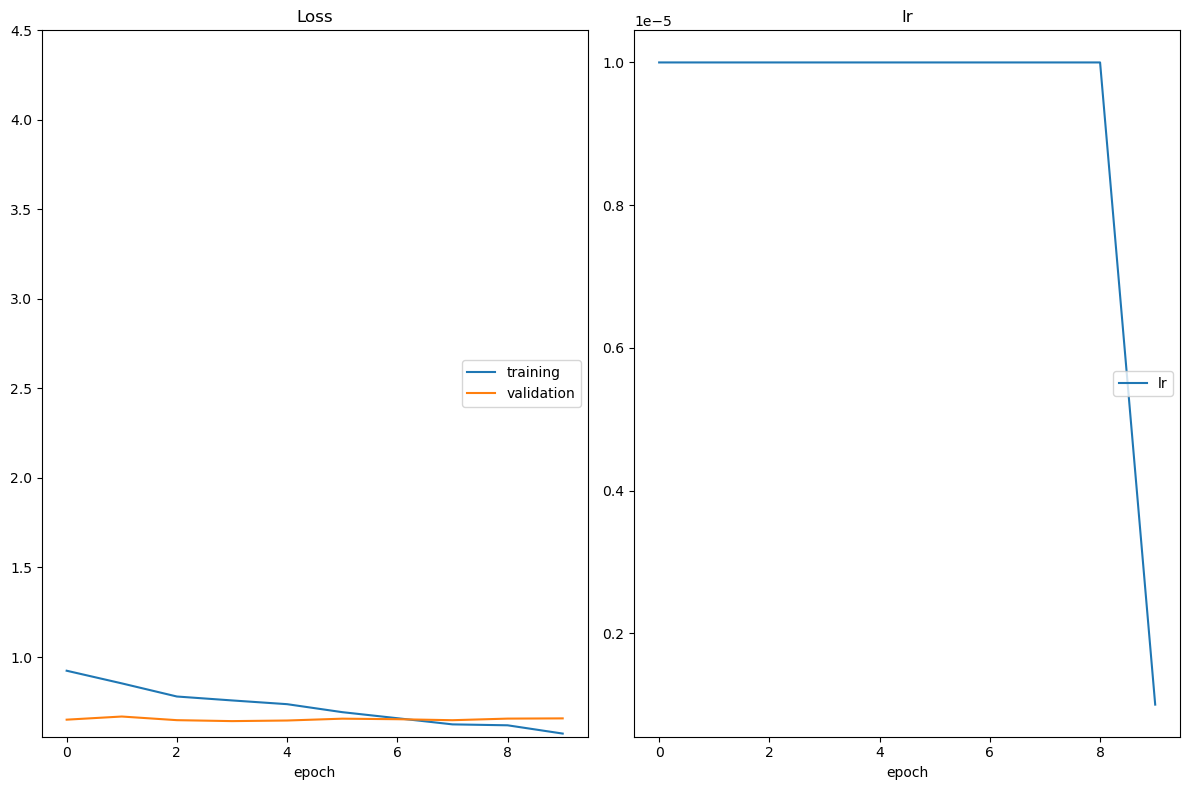

Train loss: 0.4664081633090973. Validation loss: 0.657979428768158

Train accuracy: 86.99%. Validation accuracy: 81.27%


In [26]:
continue_training(path, num_epochs=10, valid_size=valid_size)

In [27]:
import mlflow
runs = mlflow.search_runs().sort_values(by='metrics.val_loss', ascending=True)
fine_tuning = runs[runs['params.type'] == 'fine_tuning']
fine_tuning

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_acc,metrics.train_loss,metrics.val_loss,metrics.train_acc,...,params.batch_size,params.num_epochs,params.weight_decay,params.architecture,params.opt,params.dropout,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,235396ef72d14619baaae3d53948347a,0,FINISHED,file:///root/mlruns/0/235396ef72d14619baaae3d5...,2023-08-28 16:32:54.032000+00:00,2023-08-28 16:42:52.364000+00:00,81.265015,0.466408,0.657979,86.994598,...,64,10,0,B,Adam (\nParameter Group 0\n amsgrad: False\...,None,root,upset-doe-733,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
1,86d15cd96c03495886cad90ff715c9a3,0,FINISHED,file:///root/mlruns/0/86d15cd96c03495886cad90f...,2023-08-28 16:30:31.489000+00:00,2023-08-28 16:32:26.201000+00:00,81.965569,0.787156,0.658545,78.087471,...,64,1,0,B,Adam (\nParameter Group 0\n amsgrad: False\...,None,root,smiling-pig-27,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL
2,7da07aa924454775bde1aa7b4b7173f1,0,FAILED,file:///root/mlruns/0/7da07aa924454775bde1aa7b...,2023-08-28 16:19:02.984000+00:00,2023-08-28 16:28:11.719000+00:00,NaN,NaN,NaN,NaN,...,64,10,0,B,Adam (\nParameter Group 0\n amsgrad: False\...,None,root,brawny-dolphin-238,/opt/conda/lib/python3.10/site-packages/ipyker...,LOCAL


In [32]:
path = 'mlruns/0/' + fine_tuning.iloc[0, 0] +  '/artifacts/best_val_loss_transfer.pt'
path

'mlruns/0/235396ef72d14619baaae3d53948347a/artifacts/best_val_loss_transfer.pt'

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [33]:
data_loaders = get_data_loaders()
loss = get_loss()

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


In [34]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet152", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load(path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:12<00:00,  3.15it/s]

Test Loss: 0.972883


Test Accuracy: 75% (939/1250)


0.9728827811777593

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [35]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load(path, map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                          | 1/1250 [00:00<18:37,  1.12it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %388 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at /opt/conda/conda-bld/pytorch_1679586020379/work/third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████| 1250/1250 [04:25<00:00,  4.72it/s]


Accuracy: 0.744


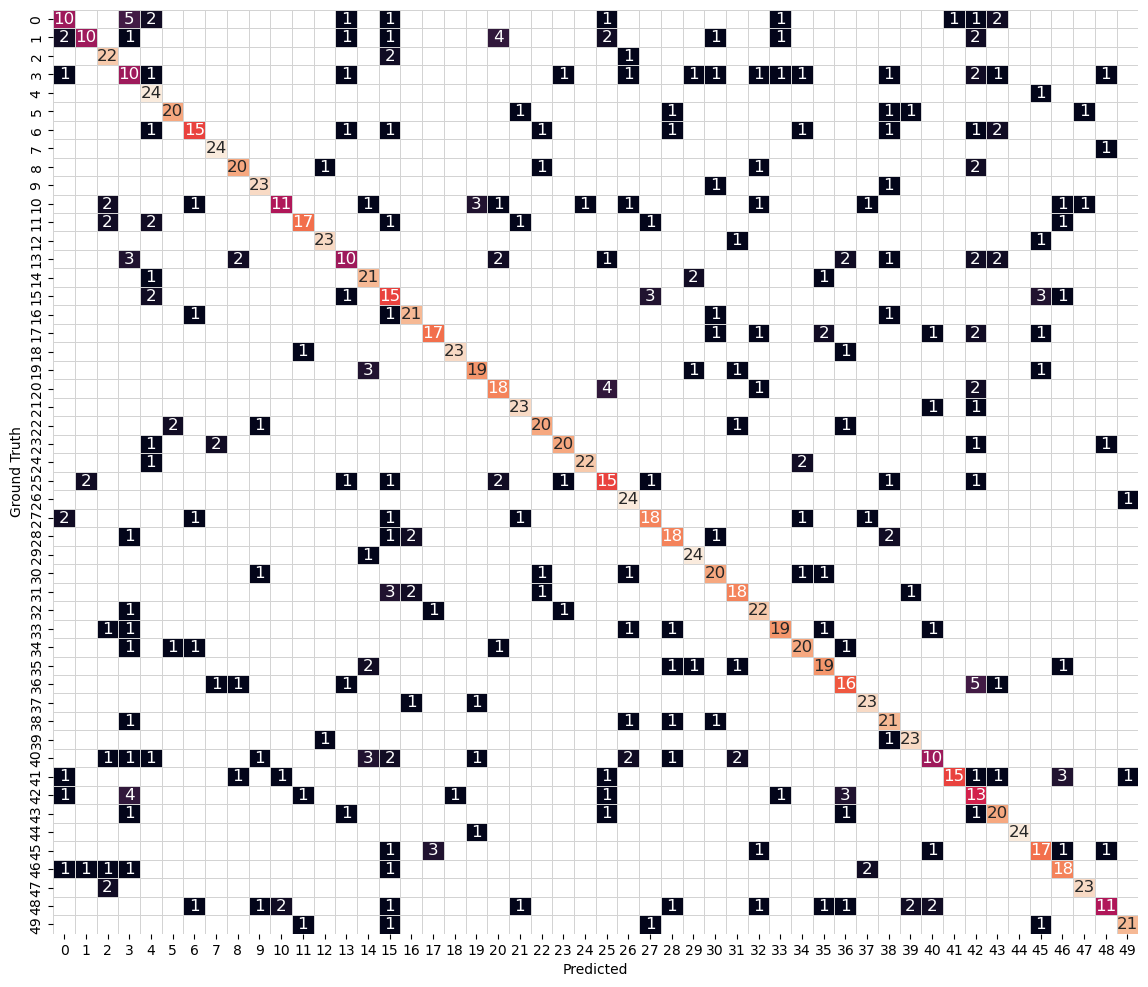

In [36]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)